# 1. Expectation Maximization

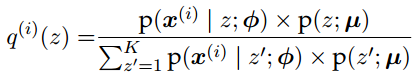

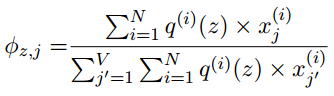

Using expectation-maximization clustering to train a word-sense induction system, applied to the word 'say'.

In [1]:
from nltk.corpus import semcor
import numpy as np
from scipy.stats import multinomial
import nltk
nltk.download('semcor')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 2.7 MB/s 


[nltk_data] Downloading package semcor to /root/nltk_data...


# Extract all sentences containing the senses SAY.V.01 and SAY.V.02.

In [2]:
# get tagged sentences

tagged_sents = semcor.tagged_sents(tag = 'sense')

# tokenize sentences

sentences = []
tokens = set()

# counts of sentences with say.v.01/say.v.02

labels = []
labels1_cnt = 0
labels2_cnt = 0
for tagged_sts in tagged_sents:
  sts = []
  label1 = False
  label2 = False
  for entity in tagged_sts:
    if entity.label() == 'say.v.01':
      label1 = True
    elif entity.label() == 'say.v.02':
      label2 = True
    else:
      sts.extend(entity.leaves())
  if label1 or label2:
    sentences.append(sts)
    tokens.update(sts)
  if label1:
    labels.append(1)
    labels1_cnt +=1
  elif label2:
    labels.append(2)
    labels2_cnt +=1

In [3]:
# show 5 samples

print(labels[:5])
for sts in sentences[:5]:
  print(' '.join(sts))

[1, 1, 1, 2, 2]
The Fulton County Grand Jury Friday an investigation of Atlanta 's recent primary election produced `` no evidence '' that any irregularities took place .
The jury further in term end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise and thanks of the City of Atlanta '' for the manner in which the election was conducted .
`` Only a relative handful of such reports was received '' , the jury , `` considering the widespread interest in the election , the number of voters and the size of this city '' .
The jury it did find that many of Georgia 's registration and election laws `` are outmoded or inadequate and often ambiguous '' .
The grand jury commented on a number of other topics , among them the Atlanta and Fulton County purchasing departments which it `` are well operated and follow generally accepted practices which inure to the best interest of both governments '' .


# Build bag-of-words vectors, containing the counts of other words in those sentences, including all words that occur in at least two sentences.

In [5]:
# words that occur in at least two sentences

vocab = []
for token in tokens:
  count = 0
  for sts in sentences:
    if token in sts:
      count += 1
      if count > 1 and token not in vocab:
        vocab.append(token)

In [6]:
N = len(sentences)
V = len(vocab)
print('Number of sentences:', N)
print('Size of vocabulary:', V)
print('Number of sentences with say.v.01:', labels1_cnt)
print('Number of sentences with say.v.02:', labels2_cnt)

Number of sentences: 1849
Size of vocabulary: 2760
Number of sentences with say.v.01: 1646
Number of sentences with say.v.02: 203


In [7]:
# Create a dictionary to keep track of index of each word

dict_idx = {}
i = 0
for word in vocab:
    dict_idx[word] = i
    i += 1

In [8]:
# Finally, the bag-of-words 2D vector:

X = np.zeros((N,V)) # input data
L = np.zeros(N)     # number of tokens in each line
for i in range(N):
  for token in sentences[i]:
    if token in dict_idx:
      X[i][dict_idx[token]] += 1
      L[i] += 1

# Implement expectation-maximization clustering on the data.

These are the variables used in the following:

k: the number of clusters: 2  
F: the φ in the formula, shape: (k,V)  
U: the prior expected frequency, shape: (k)  
Q: the posterior probability, p(z|X), shape: (N,k)

In [9]:
"""
Initialize latent parameters
"""

def initialize_FU(k):
    F = np.random.random((k, V))
    U = np.random.random(k)
    for i in range(k):
      total = sum(F[i])
      F[i] /= total
    s_total = sum(U)
    U /= s_total
    
    return F,U

In [10]:
"""
Calculate the soft distribution over clusters for each data point
"""

def calculate_Q(k, F, U):
    Q = np.zeros((N,k))
    for z in range(k):
      pz = multinomial.pmf(x=X, n=L, p=F[z])
      Q[:, z] = pz*U[z]
    for i in range(N):
      s = sum(Q[i])
      Q[i] /= s
    
    return Q

In [11]:
"""
Update the multinomial distribution parameters F and the cluster prior U
"""

def update_FU(k, Q):
    F = np.zeros((k,V))
    U = np.zeros(k)
    for j in range(k):
      for v in range(V):
        F[j][v] = np.dot(Q[:, j], X[:, v])
      s = sum(F[j])
      F[j] /= s
    for m in range(k):
      U[m] = sum(Q[:, m])
    s = sum(U)
    U /= s
      
    return F,U

In [12]:
"""
Perform EM by iteratively calculating the posterior and updating the parameters
"""

def em_algorithm(k, iterations):
    F, U = initialize_FU(k)
    for i in range(iterations):

        # calculate the posterior

        Q = calculate_Q(k, F, U)
        
        # update the parameters

        F, U = update_FU(k, Q)
        
    return Q, F, U

# Run EM clustering on a sample data

In [13]:
# save

saveX = X
saveL = L
saveN = N
saveV = V

# sample data

X = np.array([[2,5],
              [4,4],
              [1,8],
              [6,2],
              [8,2]])
L = [7,8,9,8,10]
N = 5
V = 2

# run EM

Q, F, U = em_algorithm(2, 50)

print('U:\n', U)
print('F:\n', F)
print('Q:\n', Q)

# reload

X = saveX
L = saveL
N = saveN
V = saveV

U:
 [0.57409617 0.42590383]
F:
 [[0.69366967 0.30633033]
 [0.21927118 0.78072882]]
Q:
 [[1.11465047e-01 8.88534953e-01]
 [7.61890846e-01 2.38109154e-01]
 [2.38958984e-03 9.97610410e-01]
 [9.95215487e-01 4.78451323e-03]
 [9.99519858e-01 4.80142120e-04]]


# Compute the frequency of each cluster

In [57]:
# fix the run

np.random.seed(2)
k = 2
iterations = 6
Q, F, U = em_algorithm(k, iterations)
print('Cluster Frequency:', U)

Cluster Frequency: [0.84740593 0.15259407]


In [58]:
# compute the cluster assignment accuracy

acc = 0
for i, j in enumerate(Q):
  if j[0] > j[1] and labels[i] == 1:
    acc += 1
  if j[0] < j[1] and labels[i] == 2:
    acc += 1
print('Accuracy:', acc/N)

Accuracy: 0.8085451595457004


# 2. Hierarchical Clustering

Implement Hierarchical Clustering for Name Entity Tagging

In [ ]:
# importing dependencies

import wikipedia
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
"""
Generate a list of wikipedia article titles to cluster
"""

# 'article' is a list containing the names of articles to be downloaded

articles = ["Natural language processing", "Artificial intelligence", "Data science", "Master in Data Science",
            "European Central Bank", "Chase Bank", "Financial technology", "International Monetary Fund",
            "Basketball", "Football", "College Football", "Association Football", "Swimming"]

# download and store all the articles in this variable

data=[]
for article in articles:
    if len(wikipedia.search(article)) > 0:
        a = wikipedia.search(article)[0]
        data.append(wikipedia.summary(a))

In [ ]:
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    
    return text

In [ ]:
i = 0
for text in data:
    data[i] = clean_text(text)
    i += 1

Vectorize the text data to use in hierarchical clustering using TfidfVectorizer() from sklearn library

In [ ]:
# vectorize the dataset using tfidf vectorizer and store the vectors in a separate variable

vectorizer = TfidfVectorizer(stop_words={'english'})
vecs = vectorizer.fit_transform(data)

In [ ]:
dist = 1 - cosine_similarity(vecs)

Plot the Dendrogram and see the hierarchical relationships between articles

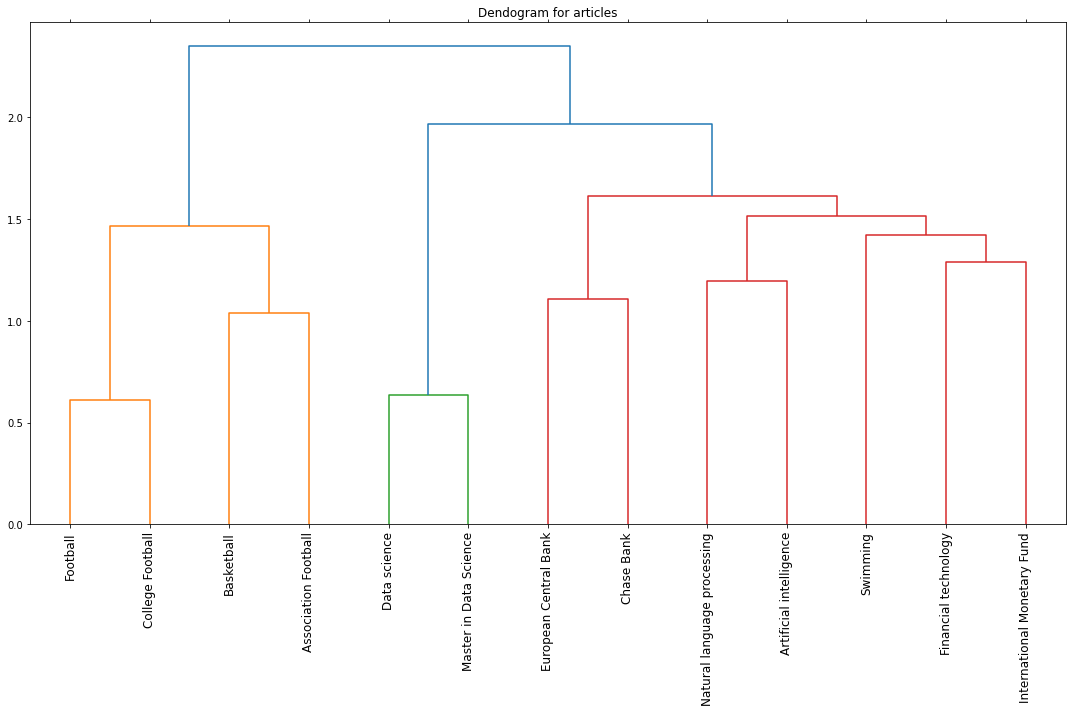

In [ ]:
# plot the dendrogram

linkage_matrix = ward(dist)
fig, ax = plt.subplots(figsize=(15, 10))
ax = dendrogram(linkage_matrix, labels=articles)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.xticks(rotation=90)
plt.title('Dendrogram for articles')
plt.tight_layout()
plt.show()

Assign cluster labels to each document/group using Agglomerative Hierarchical clustering and decide number of clusters based on the dendrogram

In [ ]:
# perform agglomerative clustering on the vectors

ac = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
clusters = ac.fit_predict(dist)
print(clusters)

[4 4 2 2 3 3 1 1 0 0 0 0 1]


Visualize top 50 words in each cluster using word clouds

Cluster 1
Articles included
- Basketball
- Football
- College Football
- Association Football


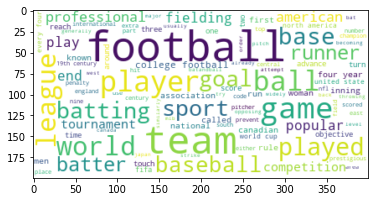

Cluster 2
Articles included
- Financial technology
- International Monetary Fund
- Swimming


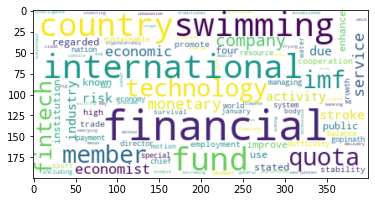

Cluster 3
Articles included
- Data science
- Master in Data Science


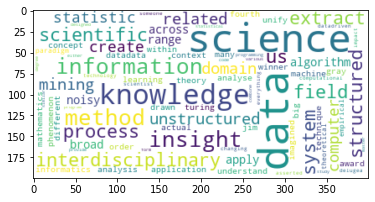

Cluster 4
Articles included
- European Central Bank
- Chase Bank


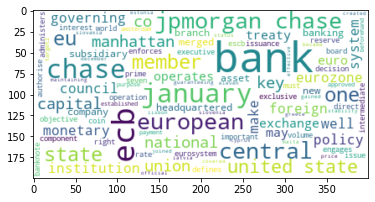

Cluster 5
Articles included
- Natural language processing
- Artificial intelligence


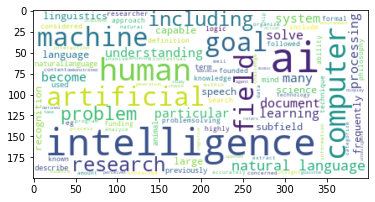

In [ ]:
# plot the clusters using word clouds

result={'cluster':clusters,'wiki':data}
result=pd.DataFrame(result)
for k in range(0, 5):
    s=result[result.cluster==k]
    text=s['wiki'].str.cat(sep=' ').lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster', k+1)
    print('Articles included')
    for i in range(len(articles)):
        if clusters[i]==k: print('- ' + articles[i]) 
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()

# 3. Parts of speech tagging.

Parts of Speech Tagging is the process of the assigning a parts of speech tag (noun, adjective, etc.) to each word in the input sentence. I have built HMMs and Viterbi Algorithm. I have used tagged datasets collected from Wall Street Journal. The dataset will contain different tags like JJ which means adjective, DT means determiner etc.

In [ ]:
# Importing necessary packages

import pandas as pd
from collections import defaultdict
import numpy as np
import math
import string

# Punctuation characters

punct = set(string.punctuation)

# Morphology rules used to assign unknown word tokens

noun_suffix = ["action", "age", "ance", "cy", "dom", "ee", "ence", "er", "hood", "ion", "ism", "ist", "ity", "ling", "ment", "ness", "or", "ry", "scape", "ship", "ty"]
verb_suffix = ["ate", "ify", "ise", "ize"]
adj_suffix = ["able", "ese", "ful", "i", "ian", "ible", "ic", "ish", "ive", "less", "ly", "ous"]
adv_suffix = ["ward", "wards", "wise"]

# Utility functions which we further need

def get_word_tag(line, vocab): 
    if not line.split():
        word = "--n--"
        tag = "--s--"
        return word, tag
    else:
        word, tag = line.split()
        if word not in vocab: 
            # Handle unknown words
            word = assign_unk(word)
        return word, tag
    return None 


def preprocess(vocab, data_fp):
    """
    Preprocess data
    """
    orig = []
    prep = []

    # Read data

    with open(data_fp, "r") as data_file:
        for cnt, word in enumerate(data_file):

            # End of sentence

            if not word.split():
                orig.append(word.strip())
                word = "--n--"
                prep.append(word)
                continue

            # Handle unknown words

            elif word.strip() not in vocab:
                orig.append(word.strip())
                word = assign_unk(word)
                prep.append(word)
                continue
            else:
                orig.append(word.strip())
                prep.append(word.strip())
    assert(len(orig) == len(open(data_fp, "r").readlines()))
    assert(len(prep) == len(open(data_fp, "r").readlines()))

    return orig, prep

def assign_unk(tok):
    """
    Assign unknown word tokens
    """

    # Digits

    if any(char.isdigit() for char in tok):
        return "--unk_digit--"

    # Punctuation

    elif any(char in punct for char in tok):
        return "--unk_punct--"

    # Upper-case

    elif any(char.isupper() for char in tok):
        return "--unk_upper--"

    # Nouns

    elif any(tok.endswith(suffix) for suffix in noun_suffix):
        return "--unk_noun--"

    # Verbs

    elif any(tok.endswith(suffix) for suffix in verb_suffix):
        return "--unk_verb--"

    # Adjectives

    elif any(tok.endswith(suffix) for suffix in adj_suffix):
        return "--unk_adj--"

    # Adverbs

    elif any(tok.endswith(suffix) for suffix in adv_suffix):
        return "--unk_adv--"

    return "--unk--"

# for viterbi

def compute_accuracy(pred, y):
    """
    Input:
        pred: a list of the predicted parts-of-speech
        y: a list of lines where each word is separated by a '\t' (i.e. word \t tag)
    Output:
    """

    num_correct = 0
    total = 0
    
    # Zip together the prediction and the labels

    for prediction, y in zip(pred, y):

        # Split the label into the word and the POS tag

        word_tag_tuple = y.split()
        
        # Check that there is actually a word and a tag, no more and no less than 2 items

        if len(word_tag_tuple)!=2:
            continue 

        # store the word and tag separately

        word, tag = word_tag_tuple
        
        # Check if the POS tag label matches the prediction

        if prediction == tag:
            
            # count the number of times that the prediction and label match

            num_correct += 1
            
        # keep track of the total number of examples (that have valid labels)

        total += 1

    return num_correct/total

# load in the training corpus

with open("/content/drive/My Drive/NLP/Assignment_4/training.pos.txt", 'r') as f:
    training_corpus = f.readlines()

# read the vocabulary data, split by each line of text, and save the list

with open("/content/drive/My Drive/NLP/Assignment_4/vocab.txt", 'r') as f:
    voc_l = f.read().split('\n')

# vocab: dictionary that has the index of the corresponding words

vocab = {} 

# Get the index of the corresponding words

for i, word in enumerate(sorted(voc_l)): 
    vocab[word] = i       

cnt = 0
for k,v in vocab.items():
    cnt += 1
    if cnt > 20:
        break

# load in the test corpus
with open("/content/drive/My Drive/NLP/Assignment_4/test.pos.txt", 'r') as f:
    y = f.readlines()

# corpus without tags, preprocessed

_, prep = preprocess(vocab, "/content/drive/My Drive/NLP/Assignment_4/test.words.txt")

Build a function which takes training_corpus as input and return transition counts, emission counts and tag counts

1. `Tranition count`: maps prev_tag, tag) to the number of times it has appeared
2. `Emission_counts`: maps (tag, word) to the number of times it appeared
3. `Tag_counts`: maps (tag) to the number of times it has occurred

In [ ]:
def create_dictionaries(training_corpus, vocab):
    """
    Input: 
        training_corpus: a corpus where each line has a word followed by its tag.
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output: 
        emission_counts: a dictionary where the keys are (tag, word) and the values are the counts
        transition_counts: a dictionary where the keys are (prev_tag, tag) and the values are the counts
        tag_counts: a dictionary where the keys are the tags and the values are the counts
    """
    
    # initialize the dictionaries using defaultdict

    emission_counts = defaultdict(int)
    transition_counts = defaultdict(int)
    tag_counts = defaultdict(int)
    
    # Initialize "prev_tag" (previous tag) with the start state, denoted by '--s--'

    prev_tag = '--s--' 
    
    # use 'i' to track the line number in the corpus

    i = 0 
    
    # Each item in the training corpus contains a word and its POS tag, Go through each word and its tag in the training corpus

    for word_tag in training_corpus:
        
        # Increment the word_tag count

        i += 1

        # get the word and tag using the get_word_tag helper function

        word_h, tag_h = get_word_tag(word_tag, vocab)
        
        # Increment the transition count for the previous word and tag

        transition_counts[(prev_tag, tag_h)] += 1
            
        # Increment the emission count for the tag and word

        emission_counts[(tag_h, word_h)] += 1
            
        # Increment the tag count

        tag_counts[tag_h] += 1
            
        # Set the previous tag to this tag (for the next iteration of the loop)

        prev_tag = tag_h
        
    return emission_counts, transition_counts, tag_counts

In [ ]:
emission_counts, transition_counts, tag_counts = create_dictionaries(training_corpus, vocab)

In [ ]:
# get all the POS states. States are parts of speech designation found in the training dataset

states = sorted(tag_counts.keys())
print(f"Number of POS tags (number of 'states'): {len(states)}")
print("View these POS tags (states)")
print(states)

Number of POS tags (number of 'states'): 46
View these POS tags (states)
['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [ ]:
print("transition examples: ")
for ex in list(transition_counts.items())[:3]:
    print(ex)
print()

print("emission examples: ")
for ex in list(emission_counts.items())[:3]:
    print (ex)
print()

print("ambiguous word example: ")
for tup,cnt in list(emission_counts.items())[:3]:
    print(tup, cnt)

transition examples: 
(('--s--', 'IN'), 5050)
(('IN', 'DT'), 32364)
(('DT', 'NNP'), 9044)

emission examples: 
(('IN', 'In'), 1735)
(('DT', 'an'), 3142)
(('NNP', 'Oct.'), 317)

ambiguous word example: 
('IN', 'In') 1735
('DT', 'an') 3142
('NNP', 'Oct.') 317


`predict_pos` function below takes preprocessed test corpus (prep), Original tagged test corpus `y`, emission counts, vocab and states. Ultimately in this function for a given preprocessed test corpus, assign a parts-of-speech tag to every word in that corpus. Using the original tagged test corpus, compute what percent of the tags are correct.

In [ ]:
def predict_pos(prep, y, emission_counts, vocab, states):
    """
    Input:
        prep: a preprocessed version of 'y'. A list with the 'word' component of the tuples.
        y: a corpus composed of a list of tuples where each tuple consists of (word, POS)
        emission_counts: a dictionary where the keys are (tag,word) tuples and the value is the count
        vocab: a dictionary where keys are words in vocabulary and value is an index
        states: a sorted list of all possible tags for this assignment
    Output:
        accuracy: Number of times you classified a word correctly
    """
    
    # Initialize the number of correct predictions to zero

    num = 0
    n = 0

    # Get the (tag, word) tuples, stored as a set

    tag_word_set = set(emission_counts.keys())

    # Get the number of (word, POS) tuples in the corpus 'y'

    den = len(y)
    for word_pos in y:

        # Split the (word, POS) string into a list of two items

        word_h, pos_h = get_word_tag(word_pos, vocab)
        
        # Verify that y_tup contain both word and POS

        if word_h and pos_h:
            
            # Set the true POS label for this word

            pos_true = pos_h

        # If the y_tup didn't contain word and POS, go to next word

        else:
            continue
        max_pos, max_pos_c = '', 0

        # If the word is in the vocabulary

        if word_h in vocab:
            for pos in states:

                # define the key as the tuple containing the POS and word

                key = (pos, word_h)

                # check if the (pos, word) key exists in the emission_counts dictionary

                if key in emission_counts:
                
                # get the emission count of the (pos,word) tuple

                    em_count = emission_counts[key]
                    n += 1

                    # keep track of the POS with the largest count

                    if em_count > max_pos_c:
                        
                        # update the final count (largest count)

                        max_pos_c = em_count
                        
                        # update the final POS

                        max_pos = pos

            # If the final POS (with the largest count) matches the true POS:

            if max_pos == pos_h:
    
                # Update the number of correct predictions

                num += 1
    accuracy = num / den

    return accuracy

In [ ]:
accuracy_predict_pos = predict_pos(prep, y, emission_counts, vocab, states)
print(f"Accuracy of prediction using predict_pos is {accuracy_predict_pos:.4f}")

Accuracy of prediction using predict_pos is 0.9307


# Building Hidden Markov Models for POS.

**Hidden Markov Models** (HMMs) are a class of probabilistic graphical model that allow us to predict a sequence of unknown (hidden) variables from a set of observed variables. <br>

The Markov Model contains a number of states and the probability of transition between those states. 
- In this case, the states are the parts-of-speech. 
- A Markov Model utilizes a transition matrix, `A`. 
- A Hidden Markov Model adds an observation or emission matrix `B` which describes the probability of a visible observation when we are in a particular state. 
- In this case, the emissions are the words in the corpus
- The state, which is hidden, is the POS tag of that word.

# Creating the 'A' transition probabilities matrix
Used Smoothing to compute the matrix

The smoothing is done as follows:

$$ P(t_i | t_{i-1}) = \frac{C(t_{i-1}, t_{i}) + \alpha }{C(t_{i-1}) +\alpha * N}$$

- $N$ is the total number of tags
- $C(t_{i-1}, t_{i})$ is the count of the tuple (previous POS, current POS) in `transition_counts` dictionary.
- $C(t_{i-1})$ is the count of the previous POS in the `tag_counts` dictionary.
- $\alpha$ is a smoothing parameter.

In [ ]:
def create_transition_matrix(alpha, tag_counts, transition_counts):
    """
    Input: 
        alpha: number used for smoothing
        tag_counts: a dictionary mapping each tag to its respective count
        transition_counts: transition count for the previous word and tag
    Output:
        A: matrix of dimension (num_tags,num_tags)
    """

    A = np.zeros(shape=(len(tag_counts), len(tag_counts)))
    for i, prev_tag in enumerate(states):
        for j, cur_tag in enumerate(states):
            A[i, j] = (transition_counts[(prev_tag, cur_tag)] + alpha) / (tag_counts[prev_tag] + (len(tag_counts)*alpha))

    return A

In [ ]:
alpha = 0.001
A = create_transition_matrix(alpha, tag_counts, transition_counts)

# Testing the function

print(f"A at row 0, col 0: {A[0,5]:.9f}")
print(f"A at row 3, col 1: {A[3,6]:.4f}")
print("View a subset of transition matrix A")
A_sub = pd.DataFrame(A[10:15,10:15], index=states[10:15], columns = states[10:15] )
print(A_sub)

A at row 0, col 0: 0.007047013
A at row 3, col 1: 0.0000
View a subset of transition matrix A
          CD        DT            EX        FW        IN
CD  0.201542  0.028850  2.734628e-08  0.000055  0.089997
DT  0.022922  0.001576  1.221866e-08  0.000257  0.009665
EX  0.000001  0.002319  1.158687e-06  0.000001  0.000001
FW  0.000004  0.008550  4.272664e-06  0.239273  0.029913
IN  0.059328  0.328388  1.582898e-03  0.000203  0.020415


# Creating 'B' emission probabilities matrix

Create the `B` transition matrix which computes the emission probability.

Used smoothing as defined below:

$$P(w_i | t_i) = \frac{C(t_i, word_i)+ \alpha}{C(t_{i}) +\alpha * N}\$$

- $C(t_i, word_i)$ is the number of times $word_i$ was associated with $tag_i$ in the training data (stored in `emission_counts` dictionary).
- $C(t_i)$ is the number of times $tag_i$ was in the training data (stored in `tag_counts` dictionary).
- $N$ is the number of words in the vocabulary
- $\alpha$ is a smoothing parameter. 

The matrix `B` is of dimension (num_tags, N), where num_tags is the number of possible parts-of-speech tags. 

In [ ]:
def create_emission_matrix(alpha, tag_counts, emission_counts, vocab):
    """
    Input: 
        alpha: tuning parameter used in smoothing 
        tag_counts: a dictionary mapping each tag to its respective count
        emission_counts: a dictionary where the keys are (tag, word) and the values are the counts'
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output:
        B: a matrix of dimension (num_tags, len(vocab))
    """
    
    B = np.zeros(shape=(len(tag_counts), len(vocab)))
    n = 0
    for i, tag in enumerate(states):
        for j, word in enumerate(vocab):
            if (tag, word) in emission_counts:
                prob = (emission_counts[(tag, word)] + alpha) / (tag_counts[tag] + (alpha * len(vocab)))
                B[i, j] = prob
            else:
                prob = alpha / (tag_counts[tag] + (alpha * len(vocab)))
                B[i, j] = prob

    return B

In [ ]:
# creating emission probability matrix

B = create_emission_matrix(alpha, tag_counts, emission_counts, list(vocab))

print(f"View Matrix position at row 0, column 0: {B[0,0]:.9f}")
print(f"View Matrix position at row 3, column 1: {B[3,1]:.9f}")

# Viewing emissions for a few words in a sample dataframe
cidx  = ['725','adroitly','engineers', 'promoted', 'synergy']

# Get the integer ID for each word
cols = [vocab[a] for a in cidx]

# Choose POS tags to show in a sample dataframe
rvals =['CD','NN','NNS', 'VB','RB','RP']

# For each POS tag, get the row number from the 'states' list
rows = [states.index(a) for a in rvals]

# Get the emissions for the sample of words, and the sample of POS tags
B_sub = pd.DataFrame(B[np.ix_(rows,cols)], index=rvals, columns = cidx )
print(B_sub)

View Matrix position at row 0, column 0: 0.000006032
View Matrix position at row 3, column 1: 0.000000720
              725      adroitly     engineers      promoted       synergy
CD   8.201296e-05  2.732854e-08  2.732854e-08  2.732854e-08  2.732854e-08
NN   7.521128e-09  7.521128e-09  7.521128e-09  7.521128e-09  2.257091e-05
NNS  1.670013e-08  1.670013e-08  4.676203e-04  1.670013e-08  1.670013e-08
VB   3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08
RB   3.226454e-08  6.456135e-05  3.226454e-08  3.226454e-08  3.226454e-08
RP   3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07


# Viterbi Algorithm

Implemented the Viterbi algorithm

* **Initialization** - Initialize the `best_paths` and `best_probabilities` matrices that will be populated in `feed_forward`
* **Feed forward** - At each step, calculate the probability of each path happening and the best paths up to that point
* **Feed backward**: Find the best path with the highest probabilities

# Initialization
Initialize the `best_probs` and the `best_paths` matrix

Both matrices will be initialized to zero except for column zero of `best_probs`
- Column zero of `best_probs` is initialized with the assumption that the first word of the corpus was preceded by a start token ("--s--")
- This allows to reference the **A** matrix for the transition probability

Here is how column 0 of `best_probs` is initialized:
- The probability of the best path going from the start index to a given POS tag indexed by integer $i$ is denoted by $\textrm{best_probs}[s_{idx}, i]$
- This is estimated as the probability that the start tag transitions to the POS denoted by index $i$: $\mathbf{A}[s_{idx}, i]$ AND that the POS tag denoted by $i$ emits the first word of the given corpus, which is $\mathbf{B}[i, vocab[corpus[0]]]$
- Note that vocab[corpus[0]] refers to the first word of the corpus (the word at position 0 of the corpus)
- **vocab** is a dictionary that returns the unique integer that refers to that particular word

In [ ]:
def initialize(states, tag_counts, A, B, corpus, vocab):
    """
    Input: 
        states: a list of all possible parts-of-speech
        tag_counts: a dictionary mapping each tag to its respective count
        A: Transition Matrix of dimension (num_tags, num_tags)
        B: Emission Matrix of dimension (num_tags, len(vocab))
        corpus: a sequence of words whose POS is to be identified in a list 
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output:
        best_probs: matrix of dimension (num_tags, len(corpus)) of floats
        best_paths: matrix of dimension (num_tags, len(corpus)) of integers
    """
    
    num_POS_tags = len(tag_counts)
    best_probs = np.zeros((num_POS_tags, len(corpus)))
    best_paths = np.zeros((num_POS_tags, len(corpus)), dtype=int)
    start_idx = states.index("--s--")
    for i in range(num_POS_tags): 
        if A[start_idx,i] == 0: 
            best_probs[i,0] = float('-inf')
        else:
            best_probs[i,0] = math.log(A[start_idx,i]) + math.log(B[i,vocab[corpus[0]]])
           
    return best_probs, best_paths

In [ ]:
best_probs, best_paths = initialize(states, tag_counts, A, B, prep, vocab)

In [ ]:
# Test the function

print(f"best_probs[0,0]: {best_probs[0,0]:.4f}") 
print(f"best_paths[2,3]: {best_paths[2,3]:.4f}")

best_probs[0,0]: -22.6098
best_paths[2,3]: 0.0000


# Viterbi Forward Implementation

Implemented the `viterbi_forward` segment. In other words, populated the `best_probs` and `best_paths` matrices
- Walk forward through the corpus
- For each word, compute a probability for each possible tag

Store the best_path and best_prob for every possible tag for each word in the matrices `best_probs` and `best_tags` using the pseudocode below

In [ ]:
def viterbi_forward(A, B, test_corpus, best_probs, best_paths, vocab, corpus):
    """
    Input: 
        A, B: The transition and emission matrices respectively
        test_corpus: a list containing a preprocessed corpus
        best_probs: an initialized matrix of dimension (num_tags, len(corpus))
        best_paths: an initialized matrix of dimension (num_tags, len(corpus))
        vocab: a dictionary where keys are words in vocabulary and value is an index 
    Output: 
        best_probs: a completed matrix of dimension (num_tags, len(corpus))
        best_paths: a completed matrix of dimension (num_tags, len(corpus))
    """

    num_POS_tags = best_probs.shape[0]
    for i in range(1, len(test_corpus)): 
        for j in range(num_POS_tags): 
            best_prob_i = float("-inf")
            best_path_i = None
            for k in range(num_POS_tags):
                probability = best_probs[k,i-1]+math.log(A[k,j]) +math.log(B[j,vocab[test_corpus[i]]])
                if probability > best_prob_i: 
                    best_prob_i = probability
                    best_path_i = k
            best_probs[j,i] = best_prob_i
            best_paths[j,i] = best_path_i

    return best_probs, best_paths

In [ ]:
best_probs, best_paths = viterbi_forward(A, B, prep, best_probs, best_paths, vocab, prep)

In [ ]:
# Test the function

print(f"best_probs[0,1]: {best_probs[0,1]:.4f}")
print(f"best_probs[0,4]: {best_probs[0,4]:.4f}")

best_probs[0,1]: -24.7822
best_probs[0,4]: -49.5601


# Viterbi Backward Implementation

<a name='2.4'></a>
# Viterbi backward

Implemented the Viterbi backward algorithm
- The Viterbi backward algorithm gets the predictions of the POS tags for each word in the corpus using the `best_paths` and the `best_probs` matrices

In [ ]:
def viterbi_backward(best_probs, best_paths, corpus, states):
    """
    This function returns the best path.
    """
    
    m = best_paths.shape[1] 
    array = [None] * m
    num_POS_tags = best_probs.shape[0]
    Best_probablity = float('-inf')
    pred = [None] * m
    for k in range(num_POS_tags):
        if best_probs[k,-1]>Best_probablity: 
            Best_probablity = best_probs[k,-1]
            array[m - 1] = k
    pred[m - 1] = states[k]
    for i in range(len(corpus)-1, -1, -1): 
        POS_tag = best_paths[np.argmax(best_probs[:,i]),i]
        array[i - 1] = best_paths[POS_tag,i]
        pred[i - 1] = states[POS_tag]

    return pred

In [ ]:
# Run and test the function

pred = viterbi_backward(best_probs, best_paths, prep, states)
m=len(pred)
print('The prediction for pred[-7:m-1] is: \n', prep[-7:m-1], "\n", pred[-7:m-1], "\n")
print('The prediction for pred[0:8] is: \n', pred[0:7], "\n", prep[0:7])

The prediction for pred[-7:m-1] is: 
 ['see', 'them', 'here', 'with', 'us', '.'] 
 ['VB', 'PRP', 'RB', 'IN', 'PRP', '.'] 

The prediction for pred[0:8] is: 
 ['DT', 'NN', 'POS', 'NN', 'MD', 'VB', 'VBN'] 
 ['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken']


Predicting on the dataset

In [ ]:
print('The word is:', prep[3])
print('Your prediction is:', pred[3])
print('Your corresponding label y is: ', y[3])
print(f"Accuracy of the Viterbi algorithm is {compute_accuracy(pred, y):.4f}")

The word is: temperature
Your prediction is: NN
Your corresponding label y is:  temperature	NN

Accuracy of the Viterbi algorithm is 0.9528
